# <center>Ensembles' Correlation plot</center>

This notebook contains the code to:
- Compare the correlation plots of the two KGs for the top disease prediction by the ensembl model

### System configurations

In [1]:
import getpass
import sys
import time
sys.path.insert(0, '..')

In [2]:
getpass.getuser()

'yojana'

In [3]:
sys.version

'3.8.13 (default, Mar 28 2022, 06:16:26) \n[Clang 12.0.0 ]'

In [4]:
time.asctime()

'Wed Sep 14 11:26:54 2022'

### Import modules

In [5]:
import os

import networkx as nx
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from scipy import stats


PLOTS_PATH = '../data/plots'
PREDICTIONS_PATH = '../data/predictions'
KG_PATH = '../data/kg'

mpl.rcParams['figure.dpi'] = 360
sns.set_style('whitegrid')

# Load predictions

In [6]:
biokg_fn = os.path.join(PREDICTIONS_PATH, 'score_combination_preds-biokg-ensemble-all.csv')
biokg_preds = pd.read_csv(biokg_fn, sep='\t')

In [7]:
openbiolink_fn = os.path.join(PREDICTIONS_PATH, 'score_combination_preds-openbiolink-ensemble-all.csv')
openbiolink_preds = pd.read_csv(openbiolink_fn, sep='\t')

### Load graph

In [8]:
networks = {}

for kg_name in ['openbiolink', 'biokg']:
    graph = nx.read_adjlist(f'{KG_PATH}/{kg_name}.adjlist')
    networks[kg_name] = graph

In [9]:
len(networks['openbiolink'].nodes()), len(networks['openbiolink'].edges()), 

(5972, 43138)

In [10]:
len(networks['biokg'].nodes()), len(networks['biokg'].edges()), 

(40654, 282738)

### Adding degree for diseases and drugs

In [11]:
def add_degree(
    col_name,
    df_dict
) -> dict:
    data = {}
    
    for kg_name, df in df_dict.items():
        if 'DOID:1574' in df['target'].values:
            _df = df[df['target'] == 'DOID:1574']
        else:
            _df = df[df['target'] == 'mesh:D008106']
        
        kg = networks[kg_name]
        
        _df = _df[['source', 'target', 'score', 'y']]
        
        ## Adding degree column
        degrees = []
        
        for node in tqdm(_df[col_name].values):
            n_degree = kg.degree(node)
            degrees.append(n_degree)
        
        _df['degree'] = degrees
        data[kg_name] = _df
    return data

In [12]:
degree_dicts = add_degree(
    df_dict={
        'biokg': biokg_preds,
        'openbiolink': openbiolink_preds
    },
    col_name='source'
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 167233.42it/s]


### Plot regression curve for most connected disease

In [13]:
def plot_scatter_distribution(
    df_dict,
    figsize=(15,10),
    save_fig=False
):

    plt.figure(figsize=figsize)
    
    for kg_name, df in df_dict.items():
        if 'DOID:1574' in df['target'].values:
            _df = df[df['target'] == 'DOID:1574']
        else:
            _df = df[df['target'] == 'mesh:D008106']

        kg = networks[kg_name]
        
        _df = _df[['source', 'score', 'degree', 'y']]
        _df.rename(columns={'y': 'test'}, inplace=True)
                        
        ax = sns.lmplot(
            data=_df,
            x='score',
            y='degree',
            hue='test',
            logx=True,
            n_boot=100,
            seed=0,
            height=6,
            aspect=1.2,
        )
        
        _, _, r_value, _, _ = stats.linregress(np.log10(_df["degree"]), _df["score"])
        ax = plt.gca()
        ax.text(0.05, 0.8, f"$R^2$: {r_value**2:.2f}", transform=ax.transAxes)
        
        ax.set_title(kg_name, y=1.0, pad=-20, fontsize=20)
                
        if kg_name == 'openbiolink':
            ax.set_ylim((0, 250))
        else:
            ax.set_ylim((0))
        ax.set_xlabel('Score', fontsize=16)
        ax.set_ylabel('Degree', fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=14)

        if save_fig:
            plt.savefig(os.path.join(PLOTS_PATH, f'{kg_name}_regplot.png'), dpi=360, bbox_inches='tight')

<Figure size 1080x720 with 0 Axes>

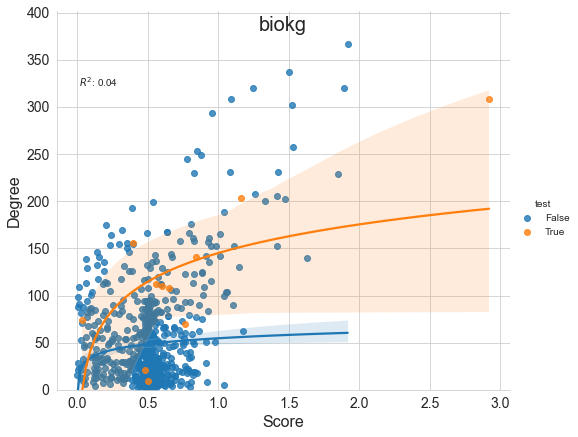

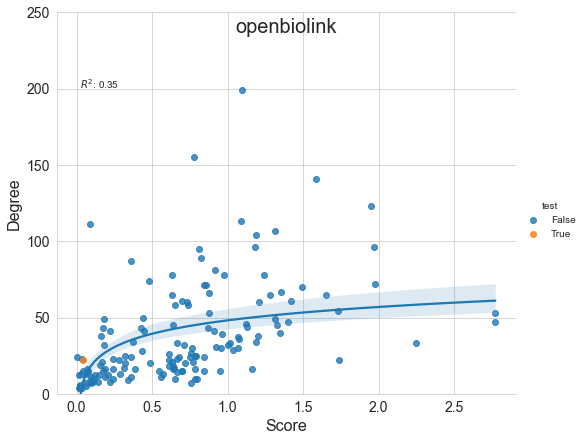

In [14]:
plot_scatter_distribution(
    df_dict=degree_dicts,
    save_fig=True,
)

### Calculate R-value for each disease

In [15]:
def get_average_correlation(
    df_dict
):
    for kg_name, df in df_dict.items():
        
        correlation = []
        
        all_diseases = set(df['target'].to_list())

        for disease in all_diseases:
            _df = df[df['target'] == disease]
            
            scores = _df['score']

            kg = networks[kg_name]
        
            ## Adding degree column
            degrees = []
            
            for node in _df['source'].values:
                n_degree = kg.degree(node)
                degrees.append(n_degree)

            _, _, r_value, _, _ = stats.linregress(np.log10(degrees), scores)

            correlation.append(round(r_value, 2))
        
        print(f'Average correlation for diseases in {kg_name} is {sum(correlation)/len(correlation)}')
    

In [16]:
get_average_correlation(
    df_dict={
        'biokg': biokg_preds,
        'openbiolink': openbiolink_preds
    }
)

Average correlation for diseases in biokg is 0.09364406779661012
Average correlation for diseases in openbiolink is 0.268235294117647


/Users/yojana/anaconda3/envs/kgem/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/yojana/anaconda3/envs/kgem/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/yojana/anaconda3/envs/kgem/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
